In [8]:
# import necessary libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

from tensorflow.keras import datasets, callbacks
from tensorflow import keras
import opendatasets as od
import pandas as pd
import os
import cv2
import shutil
import splitfolders
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [9]:
# Load the MNIST dataset
(train_data, train_labels), (test_data, test_labels) = datasets.mnist.load_data()

# Concatenate the training and test sets
all_data = np.concatenate((train_data, test_data), axis=0)
all_labels = np.concatenate((train_labels, test_labels), axis=0)

# Normalize pixel values between 0 and 1
all_data = all_data / 255.0

# Split the combined dataset into train, validation, and test sets
data_train, data_temp, labels_train, labels_temp = train_test_split(all_data, all_labels, test_size=0.4, random_state=42)
data_val, data_test, labels_val, labels_test = train_test_split(data_temp, labels_temp, test_size=0.5, random_state=42)

# Reshape data for the neural network input
data_train = data_train.reshape(-1, 28, 28, 1)
data_val = data_val.reshape(-1, 28, 28, 1)
data_test = data_test.reshape(-1, 28, 28, 1)

# Debug: Check shapes of the data
print(f"Training data shape: {all_data.shape}")
print(f"Training data shape: {data_train.shape}")
print(f"Validation data shape: {data_val.shape}")
print(f"Test data shape: {data_test.shape}")


Training data shape: (70000, 28, 28)
Training data shape: (42000, 28, 28, 1)
Validation data shape: (14000, 28, 28, 1)
Test data shape: (14000, 28, 28, 1)


In [10]:
#Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal",input_shape=(128,128,1)),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

In [11]:
#Model Building
model = tf.keras.models.Sequential()

model.add(data_augmentation)

model.add(tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu',input_shape=(28, 28, 1)))
#model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu'))
#model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu'))
#model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(128, activation='relu'))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,662,149 (6.34 MB)

 Trainable params: 1,662,149 (6.34 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Model summary
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,890 (511.29 KB)

 Trainable params: 130,890 (511.29 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Learning rate scheduler
lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

# Early stopping to avoid overfitting
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    verbose=1,
    restore_best_weights=True
)

In [14]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                #from_logits=True,
                ignore_class=None,
                reduction='sum_over_batch_size'
              ),
              metrics=['accuracy'])

# Train the model
history = model.fit(data_train, labels_train, epochs=20, 
                    batch_size=128, validation_data=(data_val, labels_val),verbose=2,
                    callbacks=[lr_scheduler, early_stopping]
                    )

Epoch 1/20
329/329 - 9s - 27ms/step - accuracy: 0.8776 - loss: 0.3902 - val_accuracy: 0.9763 - val_loss: 0.0812 - learning_rate: 0.0010
Epoch 2/20
329/329 - 7s - 21ms/step - accuracy: 0.9686 - loss: 0.1066 - val_accuracy: 0.9814 - val_loss: 0.0615 - learning_rate: 0.0010
Epoch 3/20
329/329 - 7s - 21ms/step - accuracy: 0.9798 - loss: 0.0696 - val_accuracy: 0.9864 - val_loss: 0.0445 - learning_rate: 0.0010
Epoch 4/20
329/329 - 7s - 22ms/step - accuracy: 0.9827 - loss: 0.0576 - val_accuracy: 0.9882 - val_loss: 0.0389 - learning_rate: 0.0010
Epoch 5/20
329/329 - 8s - 24ms/step - accuracy: 0.9866 - loss: 0.0465 - val_accuracy: 0.9875 - val_loss: 0.0383 - learning_rate: 0.0010
Epoch 6/20
329/329 - 8s - 24ms/step - accuracy: 0.9879 - loss: 0.0407 - val_accuracy: 0.9881 - val_loss: 0.0361 - learning_rate: 0.0010
Epoch 7/20
329/329 - 8s - 24ms/step - accuracy: 0.9896 - loss: 0.0341 - val_accuracy: 0.9894 - val_loss: 0.0356 - learning_rate: 0.0010
Epoch 8/20
329/329 - 9s - 26ms/step - accuracy: 

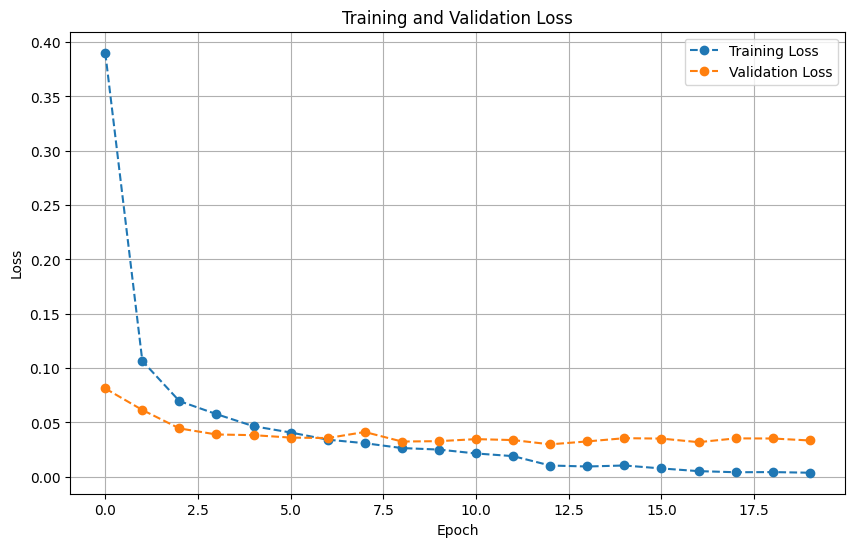

In [15]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', linestyle='--', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1419
           1       0.99      1.00      1.00      1607
           2       0.99      0.99      0.99      1403
           3       0.99      0.99      0.99      1437
           4       0.99      0.99      0.99      1326
           5       0.98      0.99      0.99      1249
           6       0.99      0.99      0.99      1351
           7       0.99      0.99      0.99      1488
           8       0.98      0.99      0.99      1319
           9       0.99      0.98      0.99      1401

    accuracy                           0.99     14000
   macro avg       0.99      0.99      0.99     14000
weighted avg       0.99      0.99      0.99     14000



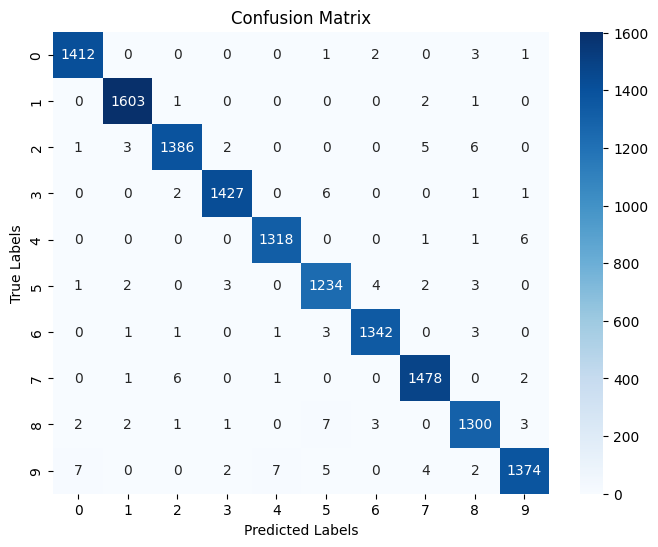

In [16]:
# Get predictions from the model
pred = model.predict(data_test)

pred_classes = np.argmax(pred, axis=1)

print(classification_report(labels_test, pred_classes, digits=2))
conf_matrix = confusion_matrix(labels_test, pred_classes)

# Confusion matrix heatmap
class_labels = [str(i) for i in range(10)]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()